<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20II%20%3A%20Business%20Applications/Chapter%2012%3A%20CRM%20%26%20Marketing%20Analytics/12_6_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CRM & Marketing Analytics**
## Recommender Systems


### A movie recommendation system based on association rule mining

[Dataset](http://files.grouplens.org/datasets/movielens/ml-latest.zip): as clean data

Data loadingfrom :  http://files.grouplens.org/datasets/movielens/ml-latest.zip as clean data 

### **Loading the dataset**
MovieLens 100Kused for the analysis \\
First, necessary libraries are installed.

In [ ]:
pip install mxnet-cu101==1.7.0 -f https://dist.mxnet.io/python


Looking in links: https://dist.mxnet.io/python


In [ ]:
pip install -U d2l

In [ ]:
import os
import pandas as pd
from mxnet import gluon, np
from d2l import mxnet as d2l


In [ ]:
#MovieLens dataset 
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

In [ ]:
%pylab inline

from collections import defaultdict
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
# #Loading the required libraries
import os
import pprint
import operator
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances

#Read the information about the data
info=d2l.DATA_HUB['ml-100k']

*   Data reading and descriptive analysis 


In [ ]:
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

*   DATA sparsity is calculated. 

In [ ]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


Distribution of movie ratings are plotted below:

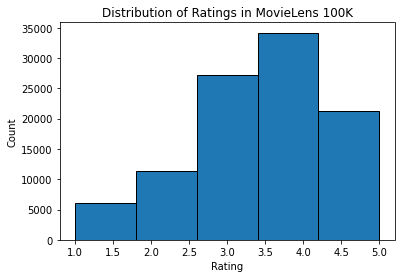

In [ ]:
d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
import requests, zipfile, io
zipfile.ZipFile(io.BytesIO(requests.get('http://files.grouplens.org/datasets/movielens/ml-latest-small.zip').content)).extractall()

In [ ]:
ls -a ml-latest-small

./  ../  links.csv  movies.csv  ratings.csv  README.txt  tags.csv


*   Necessary sub csv files are merged to use the Apriori algorithm. 

In [ ]:
data_movies = pd.read_csv('ml-latest-small/movies.csv')
data_tages = pd.read_csv('ml-latest-small/tags.csv')
data_ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [ ]:
data_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
data_movies.movieId.value_counts(),print('Number of duplicated unique ids are: ',data_movies.movieId.duplicated().sum())

Number of duplicated unique ids are:  0


(86014     1
 1282      1
 3347      1
 1298      1
 25870     1
          ..
 60072     1
 4775      1
 50601     1
 131749    1
 83969     1
 Name: movieId, Length: 9742, dtype: int64, None)

In [ ]:
data_tages.movieId.value_counts()

296     181
2959     54
924      41
293      35
7361     34
       ... 
6107      1
5878      1
5876      1
3192      1
8190      1
Name: movieId, Length: 1572, dtype: int64

In [ ]:
data_ratings.movieId.value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64

In [ ]:
merge = data_movies.merge(data_tages,on = 'movieId',how = 'inner')
merge
merge.drop(columns=['tag','timestamp','genres'],inplace=True)
len(merge.userId.unique()) 
merge_list = merge.groupby(by = ["userId"])["title"].apply(list).reset_index()
merge_list.head()

,userId,title
0,2,"[Step Brothers (2008), Step Brothers (2008), S..."
1,7,"[Departed, The (2006)]"
2,18,"[Carlito's Way (1993), Carlito's Way (1993), C..."
3,21,"[My Best Friend's Wedding (1997), My Best Frie..."
4,49,"[Interstellar (2014), Interstellar (2014), Int..."


In [ ]:
pd.get_dummies
from mlxtend.preprocessing import TransactionEncoder
#from sklearn.preprocessing import OneHotEncoder
#sklearn.preprocessing.OneHotEncoder
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(merge_list).transform(merge_list)
df = pd.DataFrame(te_ary, columns=te.columns_)
df.shape


(58, 9)

In [ ]:
pip install mlxtend --user

*   Apriori algorithm is applied for gathering accociation rules.


In [ ]:
#Aprıorı 
from mlxtend.frequent_patterns import apriori
%time
apriori_frequent_itemsets = apriori(df, min_support=0.01,use_colnames=True,max_len=2)
apriori_frequent_itemsets['itemsets'].apply(lambda x: len(x)).value_counts()


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


2    21
1     9
Name: itemsets, dtype: int64

In [ ]:
apriori_frequent_itemsets ['length'] = apriori_frequent_itemsets ['itemsets'].apply(lambda x: len(x))
apriori_frequent_itemsets 

,support,itemsets,length
0,0.017241,(I),1
1,0.017241,(d),1
2,0.034483,(e),1
3,0.017241,(i),1
4,0.017241,(l),1
5,0.017241,(r),1
6,0.017241,(s),1
7,0.017241,(t),1
8,0.017241,(u),1
9,0.017241,"(I, d)",2


In [ ]:
apriori_frequent_itemsets[(apriori_frequent_itemsets['length'] != 1)]

,support,itemsets,length
9,0.017241,"(I, d)",2
10,0.017241,"(e, I)",2
11,0.017241,"(r, I)",2
12,0.017241,"(s, I)",2
13,0.017241,"(I, u)",2
14,0.017241,"(e, d)",2
15,0.017241,"(r, d)",2
16,0.017241,"(s, d)",2
17,0.017241,"(u, d)",2
18,0.017241,"(e, i)",2


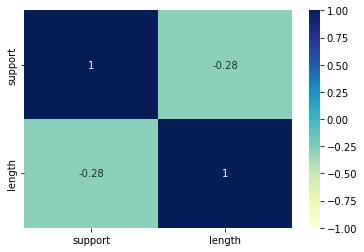

In [ ]:
import seaborn as sns
sns.heatmap(data=apriori_frequent_itemsets.corr(method='spearman'),
           annot=True,
           vmin=-1,
           vmax=1,
           center=0,
           cmap='YlGnBu');

In [ ]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(apriori_frequent_itemsets,metric="lift",min_threshold=0.01)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(I),(d),0.017241,0.017241,0.017241,1.0,58.0,0.016944,inf
1,(d),(I),0.017241,0.017241,0.017241,1.0,58.0,0.016944,inf
2,(e),(I),0.034483,0.017241,0.017241,0.5,29.0,0.016647,1.965517
3,(I),(e),0.017241,0.034483,0.017241,1.0,29.0,0.016647,inf
4,(r),(I),0.017241,0.017241,0.017241,1.0,58.0,0.016944,inf
5,(I),(r),0.017241,0.017241,0.017241,1.0,58.0,0.016944,inf
6,(s),(I),0.017241,0.017241,0.017241,1.0,58.0,0.016944,inf
7,(I),(s),0.017241,0.017241,0.017241,1.0,58.0,0.016944,inf
8,(I),(u),0.017241,0.017241,0.017241,1.0,58.0,0.016944,inf
9,(u),(I),0.017241,0.017241,0.017241,1.0,58.0,0.016944,inf


**Recommendation part:**

Extracted rules are used for collaborative filtering to suggest specialized movies 

*   Data is splitted as train and test data 

In [ ]:
#split data 
def split_data_ml100k(data, num_users, num_items, split_mode='random',
                      test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [
            True if x == 1 else False
            for x in np.random.uniform(0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

*   Re-load dataset to gather user and item indexes as implicit rating and explicit rating.

In [ ]:
#load data 
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

*   Dataset is shaped as numpy array.

In [ ]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(data, num_users, num_items,
                                              split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(train_data, num_users,
                                                    num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(test_data, num_users,
                                                 num_items, feedback)
    train_set = gluon.data.ArrayDataset(np.array(train_u), np.array(train_i),
                                        np.array(train_r))
    test_set = gluon.data.ArrayDataset(np.array(test_u), np.array(test_i),
                                       np.array(test_r))
    train_iter = gluon.data.DataLoader(train_set, shuffle=True,
                                       last_batch='rollover',
                                       batch_size=batch_size)
    test_iter = gluon.data.DataLoader(test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

In [ ]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

*   Installing embedding layer for both user and item side:

In [ ]:
class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

*   Performance metric is defined as RMSE due to the prediction of ratings. Binary crossentrophy would be used if binary classification is used.

In [ ]:
def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

*   Training phase is conducted and evaluation is used to test dataset.

In [ ]:
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None, **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

train loss 33.547, test RMSE 1.048
123115.4 examples/sec on [cpu(0)]


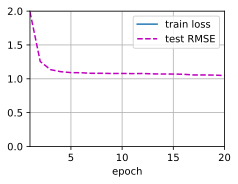

In [ ]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
net = MF(30, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer, {
    "learning_rate": lr,
    'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

### COLLABORATIVE FILTERING

In [ ]:
dataset100k = "datasets/ml-latest-small/"
dataset1M = "datasets/ml-1m"

In [ ]:
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')
dataset_handler=d2l.DATA_HUB['ml-100k'] 

In [ ]:
!pip install d2l==0.17.0
!pip install -U mxnet-cu101==1.7.0

*   For collaborative filering proper structure of **Matrix factorization** is used as embedding layers.

In [ ]:
import random
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()
class NeuMF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens,
                 **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)
        self.mlp = nn.Sequential()
        for num_hiddens in nums_hiddens:
            self.mlp.add(
                nn.Dense(num_hiddens, activation='relu', use_bias=True))
        self.prediction_layer = nn.Dense(1, activation='sigmoid',
                                         use_bias=False)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(np.concatenate([p_mlp, q_mlp], axis=1))
        con_res = np.concatenate([gmf, mlp], axis=1)
        return self.prediction_layer(con_res)

*   **Hit rate** is another metric to analyze whether ratings are properly defined as predicted or not.

In [ ]:
class PRDataset(gluon.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc
def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items,
                     devices):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_users)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        if seq is not None:
            x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)])
        test_data_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(*x),
                                               shuffle=False,
                                               last_batch="keep",
                                               batch_size=1024)
        for index, values in enumerate(test_data_iter):
            x = [
                gluon.utils.split_and_load(v, devices, even_split=False)
                for v in values]
            scores.extend([list(net(*t).asnumpy()) for t in zip(*x)])
        scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

*   Rankings are determined as the most relevant movie is shown to the user. 

In [ ]:
def train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices, evaluator,
                  candidates, eval_step=1):
    timer, hit_rate, auc = d2l.Timer(), 0, 0
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['test hit rate', 'test AUC'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            input_data = []
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            with autograd.record():
                p_pos = [net(*t) for t in zip(*input_data[0:-1])]
                p_neg = [
                    net(*t) for t in zip(*input_data[0:-2], input_data[-1])]
                ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
            [l.backward(retain_graph=False) for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        with autograd.predict_mode():
            if (epoch + 1) % eval_step == 0:
                hit_rate, auc = evaluator(net, test_iter, test_seq_iter,
                                          candidates, num_users, num_items,
                                          devices)
                animator.add(epoch + 1, (hit_rate, auc))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test hit rate {float(hit_rate):.3f}, test AUC {float(auc):.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

train loss 33.964, test hit rate 0.075, test AUC 0.531
14.9 examples/sec on [cpu(0)]


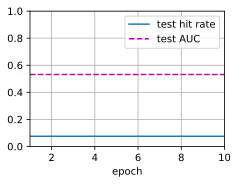

In [ ]:
batch_size = 1024
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_iter = gluon.data.DataLoader(
    PRDataset(users_train, items_train, candidates, num_items), batch_size,
    True, last_batch="rollover", num_workers=d2l.get_dataloader_workers())
devices = d2l.try_all_gpus()
net = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer, {
    "learning_rate": lr,
    'wd': wd})
train_ranking(net, train_iter, test_iter, loss, trainer, None, num_users,
              num_items, num_epochs, devices, evaluate_ranking, candidates)